# Spectral Attack Simulation on Vertical Federated Learning (vFL)
This notebook simulates a label inference attack (Spectral Attack) in a vFL scenario, where embeddings exchanged between two parties may leak private labels. We also test a defense mechanism.

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load UCI Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True).dropna()

# Reduce for faster experimentation
df = df.sample(3000, random_state=42)

# Encode categorical columns
for col in ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]:
    df[col] = LabelEncoder().fit_transform(df[col])
df["income"] = df["income"].apply(lambda x: 1 if ">50K" in x else 0)

# Feature separation
bank_features = ["education-num", "capital-gain", "hours-per-week"]
insurer_features = ["age", "sex", "race"]
Xb = StandardScaler().fit_transform(df[bank_features].values)
Xa = StandardScaler().fit_transform(df[insurer_features].values)
y = df["income"].values

# Train/test split
Xb_train, _, Xa_train, _, y_train, _ = train_test_split(Xb, Xa, y, test_size=0.2, random_state=42)
Xb_train = torch.tensor(Xb_train, dtype=torch.float32)
Xa_train = torch.tensor(Xa_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)


In [2]:

def distance_correlation(x, y):
    x = x - x.mean(0)
    y = y - y.mean(0)
    a = torch.cdist(x, x)
    b = torch.cdist(y, y)
    A = a - a.mean(0) - a.mean(1).unsqueeze(1) + a.mean()
    B = b - b.mean(0) - b.mean(1).unsqueeze(1) + b.mean()
    dcov_xy = (A * B).mean()
    dcov_xx = (A * A).mean()
    dcov_yy = (B * B).mean()
    return dcov_xy / (dcov_xx.sqrt() * dcov_yy.sqrt() + 1e-8)


In [3]:

class BankEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(3, 8), nn.ReLU(), nn.Linear(8, 5), nn.Tanh())
    def forward(self, x):
        return self.model(x)

class LabelModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 1), nn.Sigmoid())
    def forward(self, emb, x_a):
        return self.model(torch.cat([emb, x_a], dim=1))


In [4]:

def train(use_defense=False, lambda_reg=5.0, epochs=50):
    encoder = BankEncoder()
    label_model = LabelModel()
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(label_model.parameters()), lr=0.01)
    loss_fn = nn.BCELoss()
    for epoch in range(epochs):
        emb = encoder(Xb_train)
        preds = label_model(emb, Xa_train)
        loss = loss_fn(preds, y_train)
        if use_defense:
            loss += lambda_reg * distance_correlation(emb, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return encoder


In [5]:

def spectral_attack(encoder):
    encoder.eval()
    with torch.no_grad():
        emb = encoder(Xb_train).numpy()
        y_true = y_train.squeeze().numpy()
    centered = emb - emb.mean(axis=0)
    scores = TruncatedSVD(n_components=1).fit_transform(centered)[:, 0]
    clusters = KMeans(n_clusters=2, random_state=0).fit_predict(scores.reshape(-1, 1))
    auc0 = roc_auc_score(y_true, clusters)
    auc1 = roc_auc_score(y_true, 1 - clusters)
    return scores, y_true, max(auc0, auc1)


In [6]:

encoder_plain = train(use_defense=False)
encoder_def = train(use_defense=True)
scores_plain, y_plain, auc_plain = spectral_attack(encoder_plain)
scores_def, y_def, auc_def = spectral_attack(encoder_def)
print(f"AUC without defense: {auc_plain:.2f}")
print(f"AUC with defense: {auc_def:.2f}")


AUC without defense: 0.73
AUC with defense: 0.51


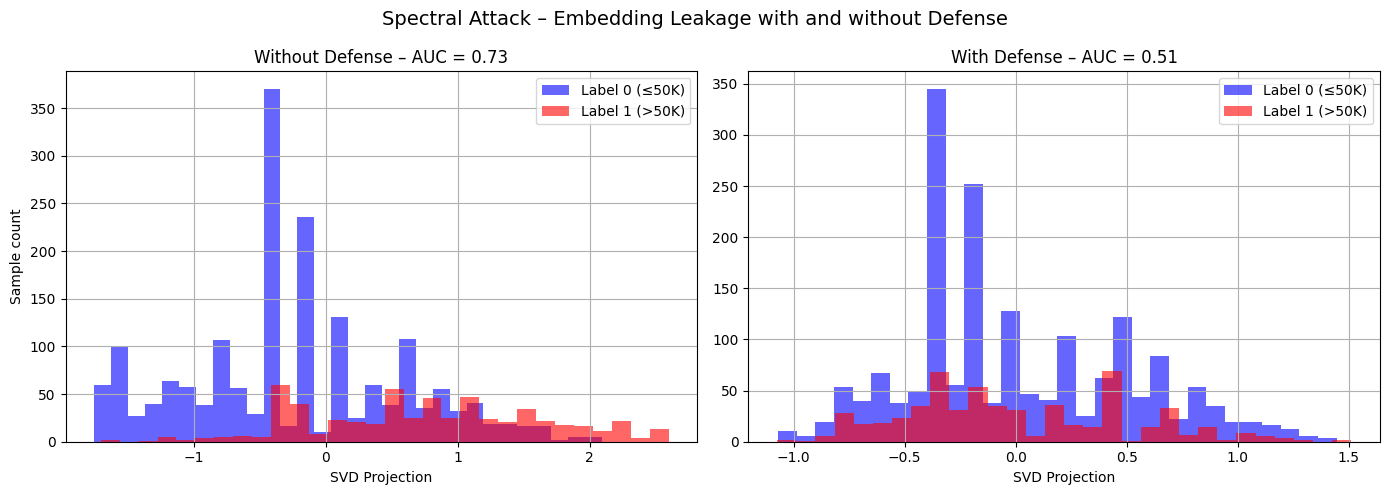

In [7]:

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(scores_plain[y_plain == 0], bins=30, alpha=0.6, label='Label 0 (≤50K)', color='blue')
plt.hist(scores_plain[y_plain == 1], bins=30, alpha=0.6, label='Label 1 (>50K)', color='red')
plt.title(f"Without Defense – AUC = {auc_plain:.2f}")
plt.xlabel("SVD Projection")
plt.ylabel("Sample count")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(scores_def[y_def == 0], bins=30, alpha=0.6, label='Label 0 (≤50K)', color='blue')
plt.hist(scores_def[y_def == 1], bins=30, alpha=0.6, label='Label 1 (>50K)', color='red')
plt.title(f"With Defense – AUC = {auc_def:.2f}")
plt.xlabel("SVD Projection")
plt.legend()
plt.grid(True)

plt.suptitle("Spectral Attack – Embedding Leakage with and without Defense", fontsize=14)
plt.tight_layout()
plt.show()
